# LoC localisation notebook

This notebook loads a set of images and segments them based on a "segmentation channel" of choice. The structure of the notebook is as follows:

1. Load images
2. Segment
3. Localise segment centroids
4. Unite cell slices over z-stack (equivalent to track over t)
5. Check labelling in Napari

Load necessary Python packages:

In [1]:
import os # this module contains functions for interacting with the operating system (i.e. list files etc)
import glob # good for finding files matching a certain extension
from skimage import io #scikit image data in/out module (for loading/saving images)
import napari # image viewer
import matplotlib.pyplot as plt # figure making module, used to display two images side by side
from tqdm.auto import tqdm # this is a counter that times how long iterative jobs take
import numpy as np # this numerical python module is good for handling images as matrices
import btrack # this is for "tracking" cells through the z-axis
from macrohet import tools # for converting mask type

# modules for loading vsi image file format
import javabridge
import bioformats
import bioformats.formatreader as F
from bioformats import metadatatools

## 1. Load images

The first step here is to define a base directory where different images for analysis are stored. By defining the path to this directory as a python variable we will reduce the need for long string input of future image paths. 

In [2]:
base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/Light microscopy/mono-culture/iAT2AT1/for analysis_20221125'
print('Here are the experimental data sets contained within base_dir:')
print(os.listdir(base_dir))

Here are the experimental data sets contained within base_dir:
['DAPI-AQP5-proSPC-ZO1', 'DAPI-SPC-PDPN-ZO1', 'DAPI-CAV1-proSPC-ZO1', 'DAPI-NKX21-PDPN-ZO1']


Next we will pick one experiment to work with from the aforementioned directories

In [3]:
expt = 'DAPI-SPC-PDPN-ZO1'
expt_dir = os.path.join(base_dir, expt) # use os to join the names of the two directories together in new python variable

And now we will show the different images from this experiment

In [4]:
print('Here are the image data sets contained within expt_dir:')
image_file_list = glob.glob(os.path.join(expt_dir, '**/*.vsi')) # using glob to find all .vsi files
# image_file_list = glob.glob(os.path.join(expt_dir, '**/*.tif')) # using glob to find all .tif files
for image_file in image_file_list:
    folder_up = os.path.basename(os.path.dirname(image_file))
    file_name = os.path.basename(image_file)
    print(f'{folder_up}/{file_name}')

Here are the image data sets contained within expt_dir:
Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245.vsi
Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_244.vsi
Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_246.vsi
Day7_static/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_123.vsi
Day7_static/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122.vsi
Day7_static/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_121.vsi


Select one set of images to work with initially (later we will iterate over all images for bulk segmentation jobs) 

In [8]:
image_dir = 'Day14_static/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_244.vsi'
image_fn = os.path.join(expt_dir, image_dir)

#### From .vsi file (WIP): 

Load images using a java/python interface. If this doesn't work then open the `.vsi` file in Fiji and save out as `.tif`, then load here. 

In [24]:
javabridge.start_vm(class_path=bioformats.JARS)
with bioformats.ImageReader(image_fn) as reader:
        image_vsi = reader.read()
# javabridge.kill_vm() # running this line means kernel has to reboot before loading another image

14:26:51.959 [Thread-0] DEBUG loci.formats.ClassList - Could not find loci.formats.in.URLReader
java.lang.ClassNotFoundException: loci.formats.in.URLReader
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:419)
	at sun.misc.Launcher$AppClassLoader.loadClass(Launcher.java:352)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:352)
	at java.lang.Class.forName0(Native Method)
	at java.lang.Class.forName(Class.java:264)
	at loci.formats.ClassList.parseLine(ClassList.java:196)
	at loci.formats.ClassList.parseFile(ClassList.java:258)
	at loci.formats.ClassList.<init>(ClassList.java:138)
14:26:51.959 [Thread-0] DEBUG loci.formats.ClassList - Could not find loci.formats.in.SlideBook6Reader
java.lang.ClassNotFoundException: loci.formats.in.SlideBook6Reader
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:419)
	at sun.misc.Launcher$AppClassLoader.loadClass(Launc

In [25]:
image_vsi.shape

(2304, 2304, 4)

#### From .tif file: 

In [5]:
%%time 
image_fn = '/mnt/DATA/lung_on_chip/coculture/20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_57.vsi - 001 CF405, CF488, CF561, CF638.tif'
image = io.imread(image_fn)
print(f'Image shape is: {image.shape} (ZXYC)')

Image shape is: (81, 2304, 2304, 4) (ZXYC)
CPU times: user 1.05 s, sys: 1.01 s, total: 2.05 s
Wall time: 2.05 s


In [6]:
image.shape

(81, 2304, 2304, 4)

#### Inspect images before proceeding (optional)

In [54]:
viewer = napari.Viewer() # initiate an instance of the napari viewer 

viewer.add_image(image,
                 channel_axis=-1)

/home/dayn/analysis/btrack/btrack/dataio.py:3: UserWarning: `btrack.dataio` has been deprecated. Please use `btrack.io` subpackage instead.
  warnings.warn(  # noqa: B028


Assistant skips harvesting pyclesperanto as it's not installed.


[<Image layer 'Image' at 0x7f0642f7f040>,
 <Image layer 'Image [1]' at 0x7f03e242d070>,
 <Image layer 'Image [2]' at 0x7f033c0a1fd0>,
 <Image layer 'Image [3]' at 0x7f0300169550>]

#### Designate channels as separate python variables

Makes life easier later down the line when you want to segment one slice

In [7]:
mask_input_channel = image[...,3] # picking ch3 as mask input

## 2. Segmentation

Activate GPU (if you have one) and defiune cellpose segmentation model

In [8]:
# print gpu information
!nvcc --version
!nvidia-smi

# load cellpose
from cellpose import core, utils, models, metrics

# check to see if GPU can be used
use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

# define segmentation model parameters
model = models.Cellpose(gpu=use_GPU, 
                        model_type='cyto') # cytoplasmic segmentation 
channels = [0,0] # this means using a grayscale image for both nuclei and cyto channels (even if not using nuclei, still have to say its same colour [greyscale = 0])

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Fri Jul 21 15:41:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 30%   46C    P2    81W / 300W |   7821MiB / 49140MiB |      2%      Default |
|                               |                      |                  N/A |
+

#### Test segmentation on a frame

This is a useful stage to assess the size difference between apical and basal cells. This can be done by using the cellpose estimation for the apical side (which is usually correctly estimated as the cells are regularly shaped and easier to automatically segment) and then inputting your own estimation for the basal cell size. The ratio between the two will be calculated and used in later segmentation. The first step in this process is to pick a frame that is representative of the apical side and another frame that is representative of the basal side. Finally, a transition point between the apical and basal regions should be defined to know which segmentation approach to apply to either. 

In [51]:
apical_index = 34  # pick which frame/zslice to test the segmentation on
basal_index = 46 # for the basal side too

transition_index = 45 # should be approximately between the two sides, when both cell types are present in minimal amounts


Estimated average apical mask diameter is: 40
Basal mask diameter is: 200


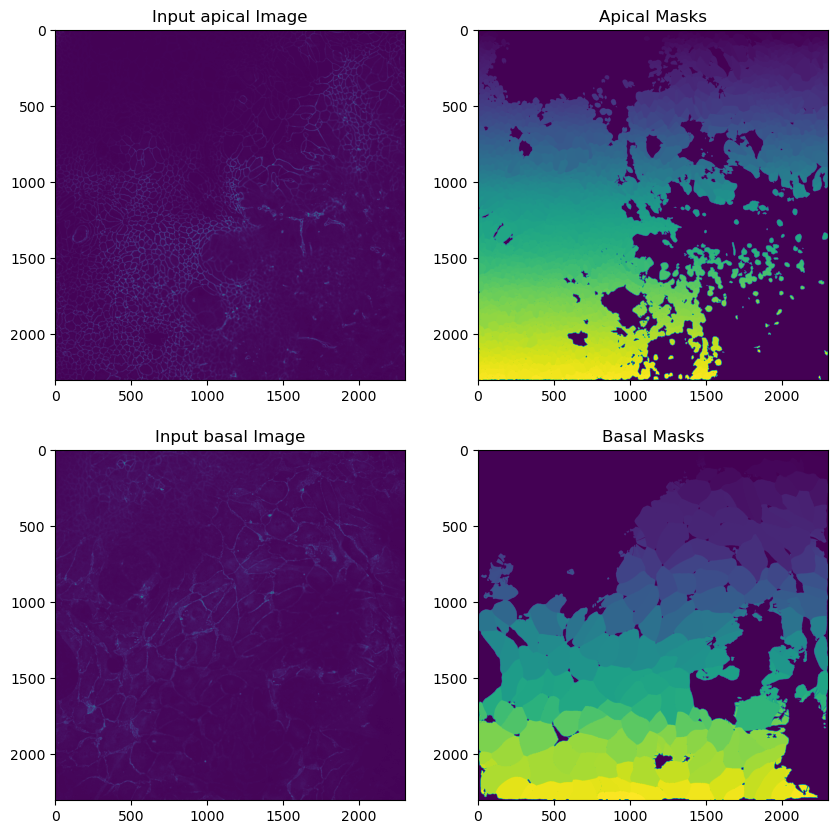

Basal to apical cell diameter ratio: 5.0
CPU times: user 16.1 s, sys: 1.44 s, total: 17.5 s
Wall time: 16.9 s


In [34]:
%%time
apical_masks, flows, styles, apical_diams = model.eval(
    mask_input_channel[apical_index],  # input image to segment
    diameter=None,  # set average cell diameter (if left to None then it estimates for you)
    flow_threshold=None,  # optional parameter to increase if cells undersegmented
    channels=channels  # channel input defined above
)
print(f"Estimated average apical mask diameter is: {apical_diams:.0f}") # print the estimated cell diameter basal_index = 48  # pick which frame/zslice to test the segmentation on

basal_masks, flows, styles, basal_diams = model.eval(
    mask_input_channel[basal_index],  # input image to segment
    diameter=200,  # set average cell diameter (if left to None then it estimates for you)
    flow_threshold=None,  # optional parameter to increase if cells undersegmented
    channels=channels  # channel input defined above
)
print(f"Basal mask diameter is: {basal_diams:.0f}") # print the estimated cell diameter basal_index = 48  # pick which frame/zslice to test the segmentation on

# Display input image and masks
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
ax1.imshow(mask_input_channel[apical_index])
ax1.set_title("Input apical Image")
ax2.imshow(apical_masks)
ax2.set_title("Apical Masks")
ax3.imshow(mask_input_channel[basal_index])
ax3.set_title("Input basal Image")
ax4.imshow(basal_masks)
ax4.set_title("Basal Masks")
plt.show()

# difference between apical and basal 
diam_ratio = round(basal_diams/apical_diams, 0)
print(f'Basal to apical cell diameter ratio: {diam_ratio}')

#### Or view segmentation results in napari (optional)

In [110]:
viewer.add_labels(apical_masks)
viewer.add_labels(basal_masks)

<Labels layer 'masks' at 0x7f277c124cd0>

### Run segmentation over whole image stack

In [49]:
%%time
### define empty mask image array (as a list)
mask_stack = []
### iterate over frames
for frame in tqdm(mask_input_channel, total = len(mask_input_channel)):
    ### run segmentation for single frame
    masks, flows, styles, diams = model.eval(frame, diameter=None, flow_threshold=None, channels=channels)
    ### append segmentation results to empty to mask image list
    mask_stack.append(masks)
# turn mask stack into an image array
mask_stack = np.stack(mask_stack, axis = 0)

  0%|          | 0/81 [00:00<?, ?it/s]

CPU times: user 11min 36s, sys: 1min 53s, total: 13min 29s
Wall time: 12min 34s


### Or run segmentation over part of image stack

Some image stacks are mostly blank along the z-axis so use a mean intensity measure to estimate which slices/frames to segment. Leave other slices/frames blank. This has the benefit of being quicker, as you are not trying to segment cells which are barely present in the images, and also simpifying the tracking task by removing irrelevant cell objects

#### Check where the cells exist within the image volume

  0%|          | 0/81 [00:00<?, ?it/s]

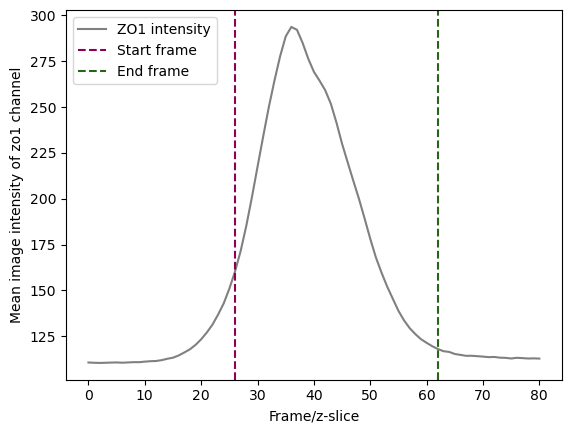

In [118]:
# define an empty list to hold mean image values
mean_measure = list()
for frame in tqdm(image[...,ch], total = len(mask_input_channel)):
    mean_measure.append(np.mean(frame))

# Set colors from "PiYG" colormap
colors = plt.cm.PiYG(np.linspace(0, 1, 2))

plt.plot(mean_measure, color = 'gray', label = 'ZO1 intensity')

# Calculate the average background signal
average_background = np.mean(mean_measure)

# Find the indices where the signal crosses above and below the average background
start_frame = np.where(mean_measure > average_background)[0][0]
end_frame = np.where(mean_measure > average_background)[0][-1] + 10 ## adding a buffer on to the end of the end_frame to aid with basal segmentation

# Draw vertical lines at the indices with respective colors
plt.axvline(x=start_frame, color=colors[0], linestyle='--', label='Start frame')
plt.axvline(x=end_frame, color=colors[1], linestyle='--', label='End frame')

plt.xlabel('Frame/z-slice')
plt.ylabel('Mean image intensity of zo1 channel')

plt.legend()  # Add a legend
plt.show()

#### Run limited scope segmentation

In [120]:
%%time
### define empty mask image array (as a list)
mask_stack = list()
### iterate over frames
for n, frame in tqdm(enumerate(mask_input_channel), total = len(mask_input_channel)):
    if start_frame < n < end_frame:
        if n < transition_index:
            ### run segmentation for apical side
            masks, flows, styles, diams = model.eval(frame, diameter=None, flow_threshold=None, channels=channels)
            apical_diams+=diams
            mean_apical_diam = apical_diams/n
        else:
            # if beyond transition frame then run basal model with larger 
            masks, flows, styles, diams = model.eval(frame, diameter=mean_apical_diam*diam_ratio, flow_threshold=None, channels=channels)
    else:
        # if beyond the focal range of the stack then just use blank array as masks
        masks = np.zeros(frame.shape, dtype = np.uint16)
    ### append segmentation results to empty to mask image list
    mask_stack.append(masks)
# turn mask stack into an image array
mask_stack = np.stack(mask_stack, axis = 0)

  0%|          | 0/81 [00:00<?, ?it/s]

CPU times: user 4min 8s, sys: 31.3 s, total: 4min 40s
Wall time: 4min 23s


## filter small segments and have unique class id for each cell type

In [ ]:
%%time
### define empty mask image array (as a list)
mask_stack = list()
### iterate over frames
for n, frame in tqdm(enumerate(mask_input_channel), total = len(mask_input_channel)):
    if start_frame < n < end_frame:
        if n < transition_index:
            ### run segmentation for apical side
            masks, flows, styles, diams = model.eval(frame, diameter=None, flow_threshold=None, channels=channels, min_size=200)
            # binarise segmentation and set classID to 1
            masks = tools.instance_to_semantic(masks)
            # record apical diams avg
            apical_diams+=diams
            mean_apical_diam = apical_diams/n
        else:
            # if beyond transition frame then run basal model with larger 
            masks, flows, styles, diams = model.eval(frame, diameter=mean_apical_diam*diam_ratio, flow_threshold=None, channels=channels, min_size=200)
            # binarise segmentation and set classID to 2
            masks = tools.instance_to_semantic(masks) * 2
    else:
        # if beyond the focal range of the stack then just use blank array as masks
        masks = np.zeros(frame.shape, dtype = np.uint16)
    ### append segmentation results to empty to mask image list
    mask_stack.append(masks)
# turn mask stack into an image array
mask_stack = np.stack(mask_stack, axis = 0)

focus on fixing frame 44 and 45 as samples

# TESTING FOR 3D

Need to make a 4D image for this

In [9]:
image = np.stack([image])

In [12]:
image.shape

(1, 81, 2304, 2304, 4)

In [10]:
image.shape

(1, 81, 2304, 2304, 4)

In [20]:
mask_input_channel_3D = image[...,-1]

In [22]:
mask_input_channel_3D.shape

(1, 81, 2304, 2304)

In [30]:
%%time
masks, flows, styles, diams = model.eval(mask_input_channel_3D, 
                                         diameter=100, 
                                         flow_threshold=None, 
                                         channels=[0,0],
                                         do_3D=True,
                                         z_axis = 1,
                                         min_size=200)

CPU times: user 5min 7s, sys: 2min 43s, total: 7min 51s
Wall time: 5min 2s


In [27]:
viewer = napari.Viewer()
viewer.add_image(mask_input_channel_3D)


<Image layer 'mask_input_channel_3D' at 0x7fd1a3d5c700>

In [28]:
masks.shape

(81, 2304, 2304)

In [29]:
viewer.add_labels(masks)

<Labels layer 'masks' at 0x7fce005b63d0>

In [157]:
help(model.eval)

Help on method eval in module cellpose.models:

eval(x, batch_size=8, channels=None, channel_axis=None, z_axis=None, invert=False, normalize=True, diameter=30.0, do_3D=False, anisotropy=None, net_avg=False, augment=False, tile=True, tile_overlap=0.1, resample=True, interp=True, flow_threshold=0.4, cellprob_threshold=0.0, min_size=15, stitch_threshold=0.0, rescale=None, progress=None, model_loaded=False) method of cellpose.models.Cellpose instance
    run cellpose and get masks
    
    Parameters
    ----------
    x: list or array of images
        can be list of 2D/3D images, or array of 2D/3D images, or 4D image array
    
    batch_size: int (optional, default 8)
        number of 224x224 patches to run simultaneously on the GPU
        (can make smaller or bigger depending on GPU memory usage)
    
    channels: list (optional, default None)
        list of channels, either of length 2 or of length number of images by 2.
        First element of list is the channel to segment (0=g

#### View segmentation results in napari (optional)

In [136]:
viewer.add_labels(mask_stack)

<Labels layer 'mask_stack [1]' at 0x7f02b5f80070>

## 3. Localise objects (cells) prior to uniting them over Z-volume

In [57]:
props = ('axis_major_length', # first define some cell properties 
         'axis_minor_length', # this helps improve the tracking
         'eccentricity',      # by comparing similarities between slices/frames
         'area', 
         'orientation',
         'mean_intensity')

In [58]:
%%time
objects = btrack.utils.segmentation_to_objects(
            segmentation = mask_stack, # set the masks here 
            intensity_image = image, # provide the image so that the mean intensity can be measured
            properties = props, # provide the cell properties to improve tracker 
            use_weighted_centroid = False, 
    
            )
print(f'{len(objects)} cell objects found in {len(mask_input_channel)} frames/z-slices')

[INFO][2023/07/21 01:35:53 pm] Localizing objects from segmentation...
21-Jul-23 13:35:53 - btrack.io._localization - INFO     - Localizing objects from segmentation...
[INFO][2023/07/21 01:35:53 pm] Processing using 28 workers.
21-Jul-23 13:35:53 - btrack.io._localization - INFO     - Processing using 28 workers.
100%|██████████████████████████████████████████████████████████| 81/81 [00:30<00:00,  2.62it/s]
[INFO][2023/07/21 01:36:26 pm] Objects are of type: <class 'dict'>
21-Jul-23 13:36:26 - btrack.io.utils - INFO     - Objects are of type: <class 'dict'>
[INFO][2023/07/21 01:36:27 pm] ...Found 55162 objects in 52 frames.
21-Jul-23 13:36:27 - btrack.io._localization - INFO     - ...Found 55162 objects in 52 frames.


55162 cell objects found in 81 frames/z-slices
CPU times: user 14.3 s, sys: 10.7 s, total: 25 s
Wall time: 33.4 s


Check that a single-cell object has the correct properties

In [61]:
objects[0]

,ID,x,y,z,t,dummy,states,label,axis_major_length,axis_minor_length,eccentricity,area,orientation,mean_intensity
0,0,20.076246,18.928152,0.0,27,False,7,5,32.911856,27.919671,0.529489,682,0.342194,"(4,) array"


#### Filter for area to avoid including small objects in tracker

In [111]:
objects = [o for o in objects if o.properties['area'] > 150]

## 4. Unite/track single-cell objects over whole image stack

This step may seem to get stuck but typically takes 20 minutes on Nathan's desktop. See btrack documentation online for tips to 

In [113]:
with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config file
        tracker.configure('/home/dayn/analysis/btrack/models/particle_config.json')
        ### set max search radius to a very limited radius 
        tracker.max_search_radius = 5
        # define tracking method
        tracker.tracking_updates = ["MOTION", "VISUAL"]
        # use visual features to track
        tracker.features = props
        # append the objects to be tracked
        tracker.append(objects)
        # set the volume
        tracker.volume=((0, mask_input_channel.shape[1]), (0, mask_input_channel.shape[2]), (-1e5, 1e5))
        # track them (in interactive mode)
        tracker.track(step_size=10)
        # generate hypotheses and run the global optimizer
        tracker.optimize()
        # get the tracks as a python list
        tracks = tracker.tracks
        # optional: get the data in a format for napari
        napari_tracks, properties, graph = tracker.to_napari(ndim=2)

[INFO][2023/07/21 01:54:40 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
21-Jul-23 13:54:40 - btrack.libwrapper - INFO     - Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2023/07/21 01:54:40 pm] Starting BayesianTracker session
21-Jul-23 13:54:40 - btrack.core - INFO     - Starting BayesianTracker session
[INFO][2023/07/21 01:54:40 pm] Loading configuration file: /home/dayn/analysis/btrack/models/particle_config.json
21-Jul-23 13:54:40 - btrack.config - INFO     - Loading configuration file: /home/dayn/analysis/btrack/models/particle_config.json
[INFO][2023/07/21 01:54:40 pm] Objects are of type: <class 'list'>
21-Jul-23 13:54:40 - btrack.io.utils - INFO     - Objects are of type: <class 'list'>
[INFO][2023/07/21 01:54:42 pm] Starting tracking... 
21-Jul-23 13:54:42 - btrack.core - INFO     - Starting tracking... 
[INFO][2023/07/21 01:54:42 pm] Update using: ['MOTION', 'VISUAL']
21-Jul-23 13:54:42 - btrack.core - INFO     - Update 

GLPK Integer Optimizer 5.0
26000 rows, 21923 columns, 30846 non-zeros
21923 integer variables, all of which are binary
Preprocessing...
13000 rows, 21923 columns, 30846 non-zeros
21923 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13000
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13000 rows, 21923 columns, 30846 non-zeros
*     0: obj =   7.952665994e+04 inf =   0.000e+00 (6548)
Perturbing LP to avoid stalling [1110]...
Removing LP perturbation [6235]...
*  6235: obj =   4.351803908e+04 inf =   0.000e+00 (0) 2
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  6235: mip =     not found yet >=              -inf        (1; 0)
+  6235: >>>>>   4.351803908e+04 >=   4.351803908e+04   0.0% (1; 0)
+  6235: mip =   4.351803908e+04 >=     tree is empty   0.0% (0; 1)
INTEGER O

[INFO][2023/07/21 01:57:36 pm] Ending BayesianTracker session
21-Jul-23 13:57:36 - btrack.core - INFO     - Ending BayesianTracker session


## 5. Check results in Napari

To make visualisation of tracks easier, recolour the masks so that a single-cell segment colour is linked to cell ID.

In [116]:
recolored_mask_stack = btrack.utils.update_segmentation(mask_stack, tracks)

Add both the tracks and recoloured mask stack to the napari viewer. 

In [117]:
viewer.add_tracks(napari_tracks, properties = properties, graph = graph,)
viewer.add_labels(recolored_mask_stack)

<Labels layer 'recolored_mask_stack' at 0x7f02c7455f10>

## 6. Save out results

In [156]:
# redefine output filename as being h5 file in same directory as image
output_fn = os.path.join(os.path.dirname(image_fn), 'z_tracks_masks.h5')
# save out 
with btrack.io.HDF5FileHandler(output_fn, 
                                   'w', 
                                   obj_type='obj_type_1'
                                   ) as writer:
        writer.write_tracks(tracks)
        writer.write_segmentation(recolored_mask_stack)

[INFO][2023/07/21 10:48:58 am] Opening HDF file: /mnt/DATA/lung_on_chip/monolayer/21-12-031B/122/z_tracks_masks.h5...
21-Jul-23 10:48:58 - btrack.io.hdf - INFO     - Opening HDF file: /mnt/DATA/lung_on_chip/monolayer/21-12-031B/122/z_tracks_masks.h5...
[INFO][2023/07/21 10:48:58 am] Writing objects/obj_type_1
21-Jul-23 10:48:58 - btrack.io.hdf - INFO     - Writing objects/obj_type_1
[INFO][2023/07/21 10:48:58 am] Writing labels/obj_type_1
21-Jul-23 10:48:58 - btrack.io.hdf - INFO     - Writing labels/obj_type_1
[INFO][2023/07/21 10:48:58 am] Loading objects/obj_type_1 (48519, 5) (48519 filtered: None)
21-Jul-23 10:48:58 - btrack.io.hdf - INFO     - Loading objects/obj_type_1 (48519, 5) (48519 filtered: None)
[INFO][2023/07/21 10:48:59 am] Writing properties/obj_type_1/axis_major_length (48519,)
21-Jul-23 10:48:59 - btrack.io.hdf - INFO     - Writing properties/obj_type_1/axis_major_length (48519,)
[INFO][2023/07/21 10:48:59 am] Writing properties/obj_type_1/axis_minor_length (48519,)
2